In [14]:
import numpy as np
import matplotlib.pyplot as plt



In [15]:
def load_bands_and_find_gap(filename, fermi_level):
    """
    Read a QE bands.x .dat.gnu file, shift energies by Fermi level,
    and compute VBM, CBM, and band gap.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    bands = []
    current_band = []

    # QE .dat.gnu format: each band is separated by a blank line
    for line in lines:
        if line.strip() == '':
            if current_band:
                bands.append(np.array(current_band))
                current_band = []
        else:
            x, y = map(float, line.split())
            y -= fermi_level  # shift energies so Fermi is at 0
            current_band.append((x, y))

    if current_band:
        bands.append(np.array(current_band))

    # Shape: list of arrays, each (N_k, 2) for one band: (k_coord, energy)
    # We want a matrix (N_k, N_bands) of energies to scan for VBM/CBM
    all_energies = np.array([band[:, 1] for band in bands]).T  # (N_k, N_bands)

    VBM = -np.inf
    CBM = np.inf
    VBM_k = -1
    CBM_k = -1

    for k_index, energies in enumerate(all_energies):
        occupied = energies[energies < 0.0]
        unoccupied = energies[energies >= 0.0]

        if occupied.size > 0 and np.max(occupied) > VBM:
            VBM = np.max(occupied)
            VBM_k = k_index

        if unoccupied.size > 0 and np.min(unoccupied) < CBM:
            CBM = np.min(unoccupied)
            CBM_k = k_index

    bandgap = CBM - VBM
    is_direct = (VBM_k == CBM_k)

    return bands, bandgap, VBM, CBM, VBM_k, CBM_k, is_direct




In [16]:
#Fermi energy for Si (in eV)
FERMI_LEVEL = 6.2487  # from pw.out

# file from bands.x
FILENAME = 'si_bands.dat.gnu'  

# High-symmetry point labels and tick positions for Si (Γ–X–U|K–Γ–L–W–X)
labels = ['Γ', 'X', 'U|K', 'Γ', 'L', 'W', 'X']
x_ticks = [0.0, 0.7071, 0.9571, 1.7071, 2.3195, 2.8195, 3.1730]


In [17]:
plt.rcParams['figure.figsize'] = (8,6)      # width, height in inches
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'

In [18]:

bands, gap, VBM, CBM, VBM_k, CBM_k, is_direct = load_bands_and_find_gap(
    FILENAME, FERMI_LEVEL
)

print(f"Si band gap: {gap:.3f} eV")
print(f"VBM = {VBM:.3f} eV at k-index {VBM_k}")
print(f"CBM = {CBM:.3f} eV at k-index {CBM_k}")
print("Gap type:", "Direct" if is_direct else "Indirect")





Si band gap: 0.497 eV
VBM = -0.308 eV at k-index 0
CBM = 0.189 eV at k-index 37
Gap type: Indirect


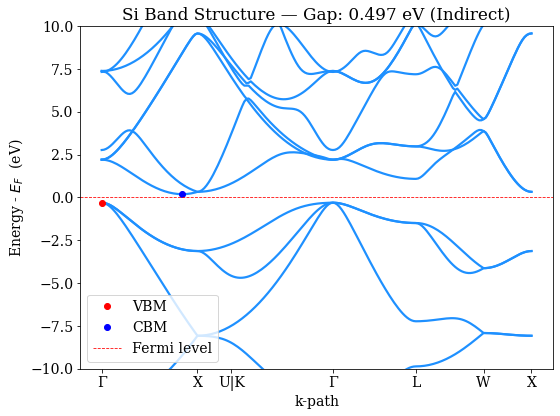

In [21]:

for band in bands:
    plt.plot(band[:, 0], band[:, 1], color='dodgerblue', lw=2.2)


x_vals = bands[0][:, 0]

# Plot VBM and CBM points
plt.plot(x_vals[VBM_k], VBM, 'ro', label='VBM')
plt.plot(x_vals[CBM_k], CBM, 'bo', label='CBM')

# Fermi level at 0 after shift
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label="Fermi level")

# Decorations: ticks at high-symmetry x positions
plt.xticks(x_ticks, labels)
plt.ylabel("Energy - $E_F$  (eV)")
plt.xlabel("k-path")
plt.ylim(-10, 10)  # adjust if your bands extend beyond this
plt.title(f"Si Band Structure — Gap: {gap:.3f} eV ({'Direct' if is_direct else 'Indirect'})")

plt.legend(loc='lower left')
plt.tight_layout()

plt.savefig('band.pdf', dpi=300)